In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [1]:
%matplotlib inline
import os
import time
import numpy as np
import pandas as pd
import sys
import cPickle as pickle
from   random import *
import scipy.stats
import matplotlib.pyplot as plt
sys.path.insert(1,'./code')
from visualize import plot_raw_data, get_population_data, plot_results
from EM import TransformToProb, RunEM
import pyparticleest.models.nlg as nlg
import pyparticleest.simulator as simulator
import pyparticleest.utils.kalman as kalman
from scipy.stats import bernoulli

//anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


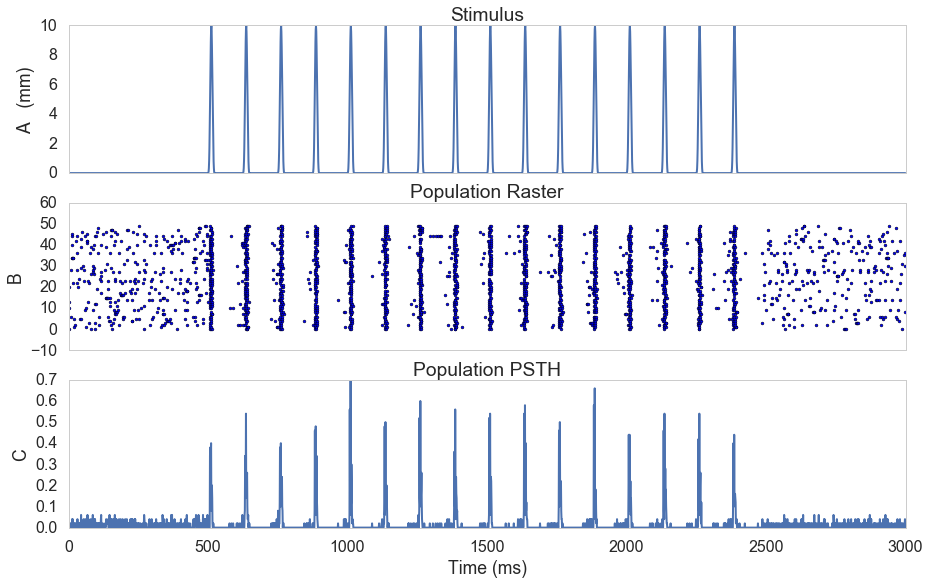

In [4]:
# Get a set of whisker data and plot the raster plot
path = 'put in path to the Data folder'
resp_values_1711 = get_population_data(17,1,1, path = path)
plot_raw_data(17,1,1,0,figsize=[15,9])

resp_values_1711 is the loaded whisker data and it's of shape (50,3000), you need to sum it up across axis 0 and then use the data.

In [12]:
print resp_values_1711.shape
Y = np.sum(resp_values_1711, axis = 0)
print Y.shape

(50, 3000)
(3000,)


initial sigma2e is 0.25

Converged after 77 iterations
sigma2e is  0.505904874894
runtime: 36.4140839577 seconds


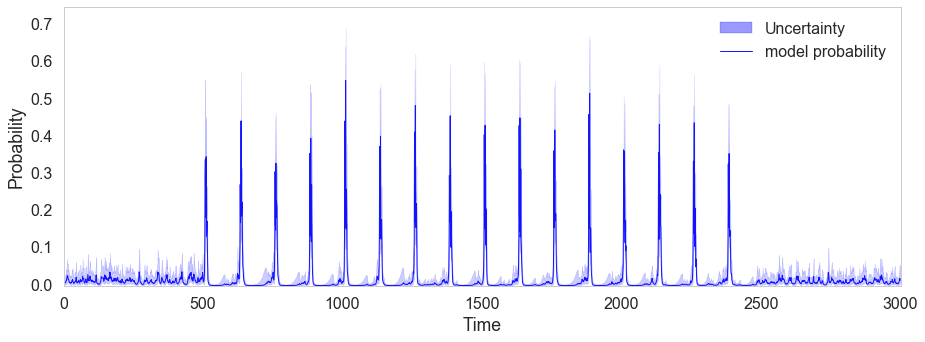

In [6]:
# Run EM on the data set and show results
pmode_1711, p_1711, pll_1711, pul_1711, sigma2e_1711 = RunEM(resp_values_1711)
plot_results(resp_values_1711, pmode_1711, p_1711, pll_1711, pul_1711, ylim=[0,0.75])

In [7]:
print sigma2e_1711

0.505904874894


Create a list of sigmas around `sigma2e_1711`.

In [10]:
sigma_ls = np.arange(sigma2e_1711-0.2, sigma2e_1711+0.2,0.01)
print len(sigma_ls)

40


Now evaluate likelikehood using the list of sigmas. Feel free to play around with the list of sigmas and the step sizes.

In [2]:
class StdNonLin(nlg.NonlinearGaussianInitialGaussian):
    # x_{k+1} = x_k  + v_k = f(x_k) + v_k,
    # y_k = 0 + e_k = g(x_k) + e_k,
    # x(0) ~ N(0,P0), v_k ~ N(0,Q), e_k ~ Binom(50,\exp(x_{k})/(1+\exp(x_{k})))

    def __init__(self, P0, Q):
    # Set covariances in the constructor since they
    # are constant
        super(StdNonLin, self).__init__(Px0=P0, Q=Q)

    def calc_g(self, particles, t):
    # Calculate value of g(\xi_t,t)
         return np.zeros([len(particles),1])
    
    def calc_f(self, particles, u, t):
    # Calculate value of f(xi_t,t)
        return particles
    
    def measure(self, particles, y, t):
        """
        Return the log-pdf value of the measurement
        Args:
         - particles  (array-like): Model specific representation
           of all particles, with first dimension = N (number of particles)
         - y (array-like):  measurement
         - t (float): time-stamp
        Returns:
         (array-like) with first dimension = N, logp(y|x^i)
        """
        N = len(particles)

        yrep = np.repeat(np.asarray(y), N, 0)
    
        lpy = scipy.stats.binom.logpmf(yrep,50,np.exp(particles[:,0])/(1.0 + np.exp(particles[:,0])),loc=0)
    
        return lpy

In [4]:
df = pd.read_csv('thaldata.csv',header=None)
Y = df.values.reshape(3000)
T = len(Y)

In [103]:
# Forward particles
N = 500
# Backward trajectories
M = 100
#iterations
iteration=500
#initial_sigma
sigma_ls = np.empty(iteration+1)
sigma_ls[0]=0.11152939 

In [104]:
%%time
for i in range(iteration):
    P0 = sigma_ls[i] * np.eye(1)    
    Q = sigma_ls[i] * np.eye(1)
    model = StdNonLin(P0, Q)
    sim = simulator.Simulator(model,u=None,y=Y)
    sim.simulate(N, M, filter='PF', smoother='ancestor', meas_first=False)
    est_smooth = sim.get_smoothed_estimates()
    posteriorcovariance=np.array(np.diff(est_smooth[:,:,0],axis=0))**2
    sigma_ls[i+1] = np.sum(posteriorcovariance/(M*T)) * np.eye(1)

CPU times: user 15min 1s, sys: 4.84 s, total: 15min 6s
Wall time: 15min 6s


15min: 3000timesteps, 500 forward, 100 backward, 500 iterations

In [26]:
a=np.random.random([2,2])
print a

[[ 0.65151123  0.80790926]
 [ 0.33385348  0.57989305]]


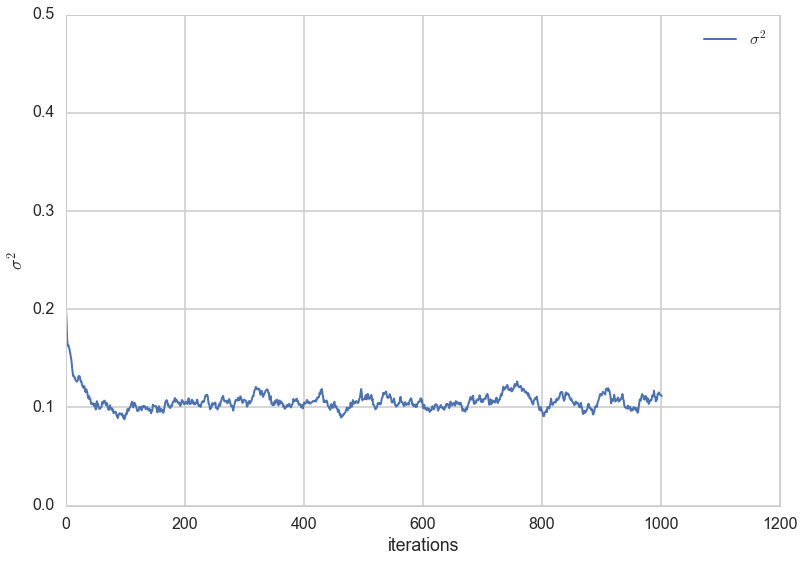

In [101]:
plt.plot(e, '-',linewidth=2.0, label=r'$\sigma^2$')
plt.ylim([0,0.5])
plt.ylabel('$\sigma^2$')
plt.xlabel('iterations')
plt.legend(loc='best')

In [ ]:
sigma_ls

In [94]:
print b.shape

(501,)


In [95]:
sigma_ls.shape

(501,)

In [100]:
e=np.reshape([b,sigma_ls],1002)